# Installing dependencies and loading data

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [23]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Feature Engineering

In [24]:
purchase_freq = transactions.groupby('CustomerID').size()  
total_spend = transactions.groupby('CustomerID')['TotalValue'].sum()  

In [25]:
customer_features = pd.DataFrame({'CustomerID': purchase_freq.index,
                                  'PurchaseFrequency': purchase_freq.values,
                                  'TotalSpend': total_spend.values})

In [26]:
customer_profile = customers[['CustomerID', 'Region', 'SignupDate']]
customer_features = pd.merge(customer_features, customer_profile, on='CustomerID')

In [27]:
customer_features['SignupDate'] = pd.to_datetime(customer_features['SignupDate'])
customer_features['AccountAge'] = (pd.to_datetime('today') - customer_features['SignupDate']).dt.days

In [28]:
customer_features = customer_features.drop(columns=['SignupDate'])

In [29]:
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

In [30]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['PurchaseFrequency', 'TotalSpend', 'AccountAge']])

In [31]:
scaled_features = np.hstack((scaled_features, customer_features.drop(columns=['PurchaseFrequency', 'TotalSpend', 'AccountAge']).values))

In [36]:
numeric_features = customer_features[['PurchaseFrequency', 'TotalSpend', 'AccountAge'] + 
                                     [col for col in customer_features.columns if col.startswith('Region_')]]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features)

# K-Means Clustering

In [37]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_features)
customer_features['Cluster'] = kmeans.labels_

In [33]:
db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])
sil_score = silhouette_score(scaled_features, customer_features['Cluster'])

print(f'Davies-Bouldin Index: {db_index}')
print(f'Silhouette Score: {sil_score}')

Davies-Bouldin Index: 1.2544936522277284
Silhouette Score: 0.319095379661456


# Visualization using PCA

In [34]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

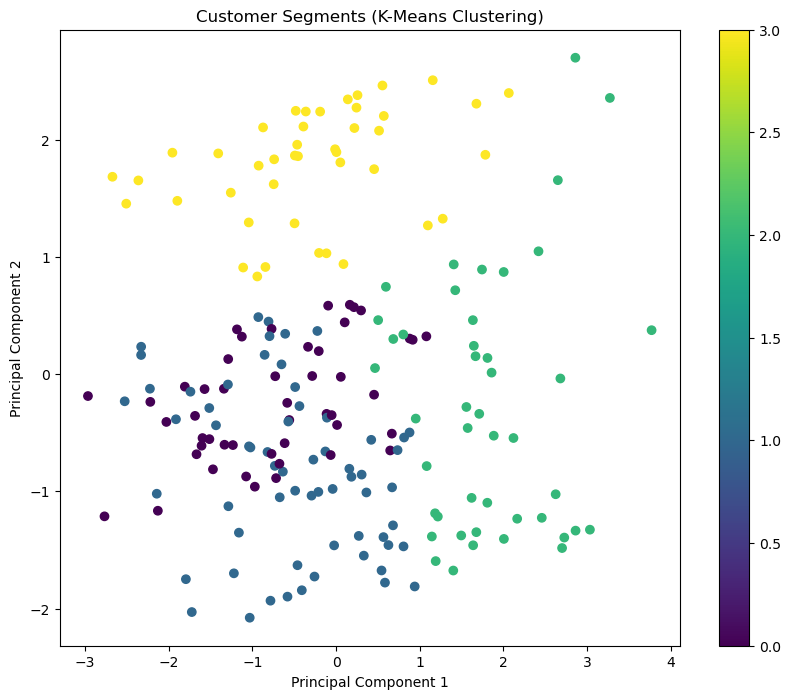

In [35]:
plt.figure(figsize=(10, 8))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=customer_features['Cluster'], cmap='viridis')
plt.title('Customer Segments (K-Means Clustering)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()